# Определение перспективного тарифа для телеком-компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов:**  

***Тариф «Смарт»***  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля  
- сообщение: 3 рубля  
- 1 Гб интернет-трафика: 200 рублей  

***Тариф «Ультра»***  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль  
- сообщение: 1 рубль  
- 1 Гб интернет-трафика: 150 рублей  

**Примечание:**  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Описание данных

***Таблица users (информация о пользователях):***  
`user_id` — уникальный идентификатор пользователя  
`first_name` — имя пользователя  
`last_name` — фамилия пользователя  
`age` — возраст пользователя (годы)  
`reg_date` — дата подключения тарифа (день, месяц, год)  
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
`city` — город проживания пользователя  
`tariff` — название тарифного плана  

***Таблица calls (информация о звонках):***  
`id` — уникальный номер звонка  
`call_date` — дата звонка  
`duration` — длительность звонка в минутах  
`user_id` — идентификатор пользователя, сделавшего звонок  

***Таблица messages (информация о сообщениях):***  
`id` — уникальный номер сообщения  
`message_date` — дата сообщения  
`user_id` — идентификатор пользователя, отправившего сообщение  

***Таблица internet (информация об интернет-сессиях):***  
`id` — уникальный номер сессии  
`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)  
`session_date` — дата интернет-сессии  
`user_id` — идентификатор пользователя  

***Таблица tariffs (информация о тарифах):***  
`tariff_name` — название тарифа  
`rub_monthly_fee` — ежемесячная абонентская плата в рублях  
`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату  
`messages_included` — количество сообщений в месяц, включённых в абонентскую плату  
`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета  
`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

## Изучение и предобработка данных

In [339]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np

pd.set_option('display.max_columns', None)

### Звонки

In [340]:
calls = pd.read_csv('/datasets/calls.csv')
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [341]:
for column in calls.columns:
    print(column)
    print(calls[column].sort_values().unique())
    print()
    print()

id
['1000_0' '1000_1' '1000_10' ... '1499_97' '1499_98' '1499_99']


call_date
['2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05'
 '2018-01-06' '2018-01-07' '2018-01-08' '2018-01-09' '2018-01-10'
 '2018-01-11' '2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15'
 '2018-01-16' '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20'
 '2018-01-21' '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25'
 '2018-01-26' '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30'
 '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04'
 '2018-02-05' '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09'
 '2018-02-10' '2018-02-11' '2018-02-12' '2018-02-13' '2018-02-14'
 '2018-02-15' '2018-02-16' '2018-02-17' '2018-02-18' '2018-02-19'
 '2018-02-20' '2018-02-21' '2018-02-22' '2018-02-23' '2018-02-24'
 '2018-02-25' '2018-02-26' '2018-02-27' '2018-02-28' '2018-03-01'
 '2018-03-02' '2018-03-03' '2018-03-04' '2018-03-05' '2018-03-06'
 '2018-03-07' '2018-03-08' '2018-03-09' '2018-03-10' '2018-03-1

In [342]:
calls.duplicated().sum()

0

Пропусков нет, дубликатов нет, намеков на скрытые дубликаты тоже, все чисто и аккуратно.  
`call_date` необходтимо привести к формату даты.

In [343]:
#изменим тип данных и проверим
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y/%m/%d")
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


### Интернет

In [344]:
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
internet.info()
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [345]:
for column in internet.columns:
    print(column)
    print(internet[column].sort_values().unique())
    print()
    print()

id
['1000_0' '1000_1' '1000_10' ... '1499_97' '1499_98' '1499_99']


mb_used
[0.00000e+00 3.00000e-02 4.00000e-02 ... 1.65155e+03 1.70275e+03
 1.72483e+03]


session_date
['2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05'
 '2018-01-06' '2018-01-07' '2018-01-08' '2018-01-09' '2018-01-10'
 '2018-01-11' '2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15'
 '2018-01-16' '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20'
 '2018-01-21' '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25'
 '2018-01-26' '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30'
 '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04'
 '2018-02-05' '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09'
 '2018-02-10' '2018-02-11' '2018-02-12' '2018-02-13' '2018-02-14'
 '2018-02-15' '2018-02-16' '2018-02-17' '2018-02-18' '2018-02-19'
 '2018-02-20' '2018-02-21' '2018-02-22' '2018-02-23' '2018-02-24'
 '2018-02-25' '2018-02-26' '2018-02-27' '2018-02-28' '2018-03-01'
 '2018-03-02' '2018-03-03' '2018-03-0

In [346]:
internet.duplicated().sum()

0

Пропусков нет, дубликатов нет, намеков на скрытые дубликаты тоже, все чисто и аккуратно.  
`session_date` необходимо изменить тип данных на дату.  

In [347]:
#изменим тип данных и проверим
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y/%m/%d")
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


### Сообщения

In [348]:
messages = pd.read_csv('/datasets/messages.csv')
messages.info()
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [349]:
for column in messages.columns:
    print(column)
    print(messages[column].sort_values().unique())
    print()
    print()

id
['1000_0' '1000_1' '1000_10' ... '1499_97' '1499_98' '1499_99']


message_date
['2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05' '2018-01-06'
 '2018-01-07' '2018-01-08' '2018-01-09' '2018-01-10' '2018-01-11'
 '2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15' '2018-01-16'
 '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20' '2018-01-21'
 '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25' '2018-01-26'
 '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30' '2018-01-31'
 '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04' '2018-02-05'
 '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09' '2018-02-10'
 '2018-02-11' '2018-02-12' '2018-02-13' '2018-02-14' '2018-02-15'
 '2018-02-16' '2018-02-17' '2018-02-18' '2018-02-19' '2018-02-20'
 '2018-02-21' '2018-02-22' '2018-02-23' '2018-02-24' '2018-02-25'
 '2018-02-26' '2018-02-27' '2018-02-28' '2018-03-01' '2018-03-02'
 '2018-03-03' '2018-03-04' '2018-03-05' '2018-03-06' '2018-03-07'
 '2018-03-08' '2018-03-09' '2018-03-10' '2018-03-11' '2018-0

In [350]:
messages.duplicated().sum()

0

Пропусков нет, дубликатов нет, намеков на скрытые дубликаты тоже, все чисто и аккуратно.  
Необходимо изменить тип данных `message_date` на дату-время.

In [351]:
#изменим тип данных и проверим
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y/%m/%d")
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


### Тарифы

In [352]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()
tariffs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Пропусков нет, дубликатов нет, намеков на скрытые дубликаты тоже, все чисто и аккуратно.

### Абоненты

In [353]:
users = pd.read_csv('/datasets/users.csv')
users.info()
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [354]:
for column in users.columns:
    print(column)
    print(users[column].sort_values().unique())
    print()
    print()

user_id
[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 119

In [355]:
users.duplicated().sum()

0

Пропусков нет, дубликатов нет, намеков на скрытые дубликаты тоже, все чисто и аккуратно.  
В данных есть звонки с нулевой продолжительностью. Согласно описанию задачи это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.
Необходимо изменить тип данных на дату-время столбцов `churn_date` и `reg_date`.

In [356]:
#изменим тип данных и проверим
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y/%m/%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y/%m/%d")
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Вывод

Данные аккуратные, типы данных стобцов с датой изменены на соответствующий тип, кдален лишний столбец из таблицы Интернет. Дубликатов и намеков на скрытые дубликаты нет.  

Исследуем данные на аномалии.

## Исследовательский анализ данных

Исследуем на предмет аномалий те данные, которые нам важны в контексте задания: звонки и пакеты данных в интернете. Сообщения и тарифы вопросов не вызывают, абоненты интересны только количеством абонентов на каждом тарифе (ФИО, город, возраст - в контексте исследования не важны).

### Звонки

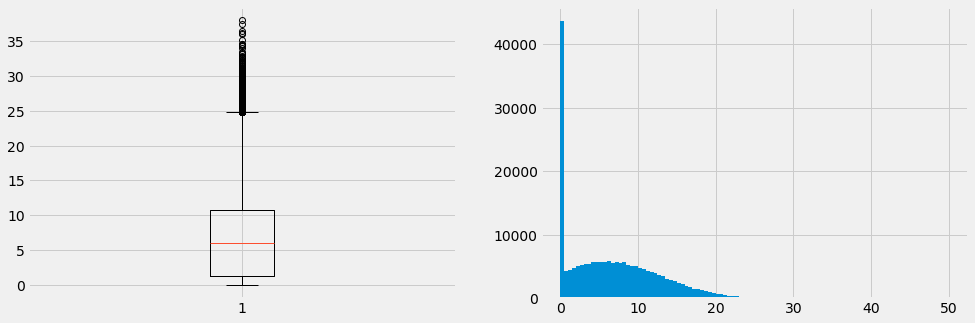

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

In [357]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].boxplot(calls['duration'])
axs[1].hist(calls["duration"], range= (0,50), bins=100, rwidth=1)

plt.show()
calls['duration'].describe()

Согласно заданию звонки длительностью 0 секунд не аномалия - это пропущенные звонки. Построим гистограмму без них.

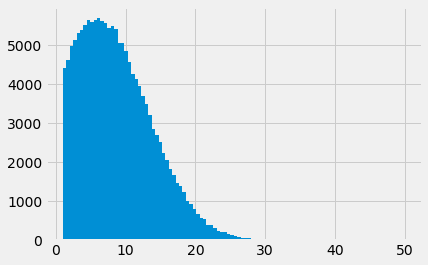

In [358]:
plt.hist(calls["duration"], range= (1,50), bins=100, rwidth=1)
plt.show()

Кто-то любит поговорить. Распределение красивое и похоже на естественное, отсекать выбросы не будем - на выбросах компания и зарабатывает дополнительную плату сверх тарифного пакета.

### Интернет

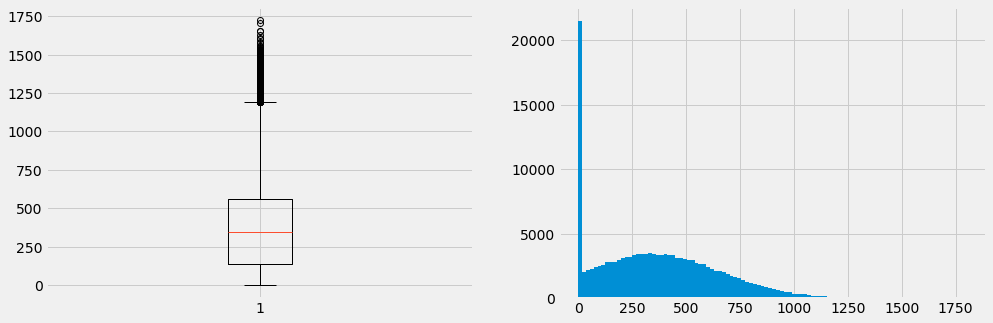

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [359]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].boxplot(internet['mb_used'])
axs[1].hist(internet["mb_used"], range= (0,1800), bins=100, rwidth=1)

plt.show()
internet['mb_used'].describe()

Интересно что это за пакеты в 0 мегабайт за сессию. Нужны ли они?

In [360]:
display(internet.query('mb_used == 0'))
internet.info()

,id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499
149381,1499_142,0.0,2018-11-01,1499
149383,1499_144,0.0,2018-11-27,1499
149386,1499_147,0.0,2018-10-21,1499


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


Похоже, что никакой нужной информации в контексте цели иследования эти 20 тысяч строк (из почти 150 тысяч) не несут. Похоже, что сессии закончились не состоявшись, может были сбои соединения. Удалим и построим гситограмму без них.

In [361]:
internet = internet.query('mb_used != 0')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            129798 non-null  object        
 1   mb_used       129798 non-null  float64       
 2   session_date  129798 non-null  datetime64[ns]
 3   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.0+ MB


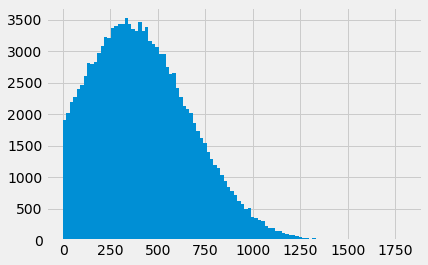

In [362]:
plt.hist(internet["mb_used"], range= (0,1800), bins=100, rwidth=1)
plt.show()

Распределение красивое и похоже на естественное, отсекать выбросы не будем - на выбросах компания и зарабатывает дополнительную плату сверх тарифного пакета.

### Абоненты

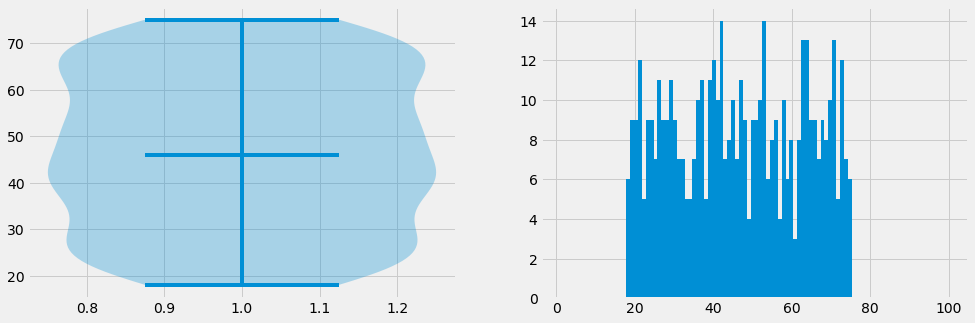

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [363]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].violinplot(users["age"],
                  showmeans=False,
                  showmedians=True)
axs[1].hist(users["age"], range= (1,100), bins=100, rwidth=1)

plt.show()
users['age'].describe()

Красивое. Распределение по возрасту не похоже на нормальное, странные провалы в 30 и 50-60 лет. Но к цели исследования отношения не имеет.

In [364]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [365]:
users['city'].value_counts().head(15)

Москва              99
Санкт-Петербург     39
Новосибирск         16
Казань              14
Омск                14
Уфа                 12
Ульяновск           11
Краснодар           11
Набережные Челны    11
Екатеринбург        11
Самара               9
Челябинск            9
Волгоград            8
Нижний Новгород      8
Пермь                8
Name: city, dtype: int64

In [366]:
users['city'].value_counts().tail(15)

Кемерово         2
Ижевск           2
Тамбов           2
Оренбург         2
Курск            2
Сургут           2
Белгород         2
Владикавказ      2
Волжский         2
Смоленск         2
Подольск         1
Иваново          1
Архангельск      1
Нижневартовск    1
Химки            1
Name: city, dtype: int64

Примерно треть пользователей на дорогом тарифе Ультра, примерно две трети - сермяжный Смарт. Пятая часть абонентов из Москвы, еще примерно 8% из Питера из остальных городов существенно меньше. Химки - почетное последнее место.

### Вывод

Распределения красивые, выбросы не отсекаем - на них компания и зарабатывает дополнительные деньги сверх тарифа. Почистили таблицу Интернет от нулевых сессий.

## Расчеты и группировка данных

**Посчитаем для каждого пользователя:**  

-  количество сделанных звонков и израсходованных минут разговора по месяцам;  

- количество отправленных сообщений по месяцам;  

- объем израсходованного интернет-трафика по месяцам;  

- помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

**Шаги:**  
1. Сначала сгруппируем данные по звонкам, интнернету и сообщениям по абонентам и месяцам.  
2. Объединим в одну таблицу и добавим информацию о тарифе каждого пользователя.
3. Рассчитаем и добавим выручку по каждому пользователю.

### Звонки

In [367]:
#добавим месяц
#calls['month'] = pd.DatetimeIndex(calls['call_date']).month 
calls['month'] = calls['call_date'].astype('datetime64[M]')
calls.head(5)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,2018-07-01
1,1000_1,2018-08-17,0.00,1000,2018-08-01
2,1000_2,2018-06-11,2.85,1000,2018-06-01
3,1000_3,2018-09-21,13.80,1000,2018-09-01
4,1000_4,2018-12-15,5.18,1000,2018-12-01


In [368]:
# округлим каждый звонок до минуты в большую сторону
import math

#calls['duration'] = [math.ceil(x) for x in calls['duration']] 
calls['duration'] = np.ceil(calls['duration'])    
calls.head(5)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,2018-07-01
1,1000_1,2018-08-17,0.0,1000,2018-08-01
2,1000_2,2018-06-11,3.0,1000,2018-06-01
3,1000_3,2018-09-21,14.0,1000,2018-09-01
4,1000_4,2018-12-15,6.0,1000,2018-12-01


In [369]:
#группируем по абонентам
calls_month = pd.pivot_table(calls, index=['user_id', 'month'], values='duration', aggfunc=['sum','count'])
calls_month = calls_month.reset_index() #сбросим мультииндекс по строкам
calls_month.columns = [("_".join(c) if c[1] != "" else c[0]) for c in calls_month.columns] #разровняем столбцы
calls_month.rename(columns={"sum_duration": "sum_calls_duration", "count_duration": "count_calls"}, inplace=True) #переименуем столбцы
calls_month.head()

,user_id,month,sum_calls_duration,count_calls
0,1000,2018-05-01,159.0,22
1,1000,2018-06-01,172.0,43
2,1000,2018-07-01,340.0,47
3,1000,2018-08-01,408.0,52
4,1000,2018-09-01,466.0,58


### Интернет

In [370]:
#добавим месяц
#internet['month'] = pd.DatetimeIndex(internet['session_date']).month 
internet['month'] = internet['session_date'].astype('datetime64[M]')
internet.head(5)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01


In [371]:
#группируем по абонентам
internet_month = pd.pivot_table(internet, index=['user_id', 'month'], values='mb_used', aggfunc=['sum','count'])
internet_month = internet_month.reset_index() #сбросим мультииндекс по строкам
internet_month.columns = [("_".join(c) if c[1] != "" else c[0]) for c in internet_month.columns] #разровняем столбцы
internet_month.head()

,user_id,month,sum_mb_used,count_mb_used
0,1000,2018-05-01,2253.49,4
1,1000,2018-06-01,23233.77,44
2,1000,2018-07-01,14003.64,28
3,1000,2018-08-01,14055.93,27
4,1000,2018-09-01,14568.91,25


In [372]:
# округлим потраченные в каждом месяце мегабайты до гигабайт в большую сторону и приведем к гигабайтам
internet_month['sum_mb_used'] = [((x - x % 1024) / 1024 + 1) for x in internet_month['sum_mb_used']] 
internet_month.rename(columns={"sum_mb_used": "sum_gb_used", "count_mb_used": "count_internet_sessions"}, inplace=True) #переименуем столбцы
internet_month.head()

,user_id,month,sum_gb_used,count_internet_sessions
0,1000,2018-05-01,3.0,4
1,1000,2018-06-01,23.0,44
2,1000,2018-07-01,14.0,28
3,1000,2018-08-01,14.0,27
4,1000,2018-09-01,15.0,25


### Сообщения

In [373]:
#добавим месяц
#messages['month'] = pd.DatetimeIndex(messages['message_date']).month 
messages['month'] = messages['message_date'].astype('datetime64[M]')
messages.head(5)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


In [374]:
#группируем по абонентам
messages_month = pd.pivot_table(messages, index=['user_id', 'month'], values='id', aggfunc=['count'])
messages_month = messages_month.reset_index() #сбросим мультииндекс по строкам
messages_month.columns = [("_".join(c) if c[1] != "" else c[0]) for c in messages_month.columns] #разровняем столбцы
messages_month.rename(columns={"count_id": "count_messages"}, inplace=True) #переименуем столбцы
messages_month.head()

,user_id,month,count_messages
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


### Объединение таблиц

In [375]:
import functools
dfs = [calls_month, internet_month, messages_month]
merge = functools.partial(pd.merge, on=['user_id', 'month'], how='outer')
stat = functools.reduce(merge, dfs)
display(stat.head())
stat.info()

,user_id,month,sum_calls_duration,count_calls,sum_gb_used,count_internet_sessions,count_messages
0,1000,2018-05-01,159.0,22.0,3.0,4.0,22.0
1,1000,2018-06-01,172.0,43.0,23.0,44.0,60.0
2,1000,2018-07-01,340.0,47.0,14.0,28.0,75.0
3,1000,2018-08-01,408.0,52.0,14.0,27.0,81.0
4,1000,2018-09-01,466.0,58.0,15.0,25.0,57.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  3214 non-null   int64         
 1   month                    3214 non-null   datetime64[ns]
 2   sum_calls_duration       3174 non-null   float64       
 3   count_calls              3174 non-null   float64       
 4   sum_gb_used              3201 non-null   float64       
 5   count_internet_sessions  3201 non-null   float64       
 6   count_messages           2717 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 200.9 KB


Судя по количеству ненулевых значений в звонках, интернете и сообщениях - таблицы объединены правильно. Проверим: найдем пользователя, у которого в трех исходных таблицах в некоторых месяцах не было чего-то из полного набора (например, он заходил в интернет, но не отправлял сообщения и не звонил. И проверим все ли данные вошли в итоговую таблицу.

In [376]:
stat[stat['count_messages'].isna()]

,user_id,month,sum_calls_duration,count_calls,sum_gb_used,count_internet_sessions,count_messages
8,1001,2018-11-01,430.0,59.0,18.0,47.0,NaN
9,1001,2018-12-01,414.0,63.0,14.0,35.0,NaN
42,1006,2018-02-01,42.0,3.0,2.0,4.0,NaN
43,1006,2018-03-01,286.0,46.0,17.0,43.0,NaN
44,1006,2018-04-01,356.0,47.0,14.0,33.0,NaN
...,...,...,...,...,...,...,...
3142,1494,2018-09-01,501.0,66.0,17.0,47.0,NaN
3143,1494,2018-10-01,354.0,52.0,18.0,53.0,NaN
3144,1494,2018-11-01,411.0,63.0,18.0,42.0,NaN
3145,1494,2018-12-01,418.0,62.0,18.0,44.0,NaN


In [377]:
internet_month.query('user_id == 1476')

,user_id,month,sum_gb_used,count_internet_sessions
3051,1476,2018-04-01,1.0,1
3052,1476,2018-05-01,22.0,43
3053,1476,2018-06-01,15.0,28
3054,1476,2018-07-01,16.0,37
3055,1476,2018-08-01,25.0,43
3056,1476,2018-09-01,19.0,37
3057,1476,2018-10-01,25.0,46
3058,1476,2018-11-01,15.0,27
3059,1476,2018-12-01,14.0,29


In [378]:
messages_month.query('user_id == 1476')

,user_id,month,count_messages
2579,1476,2018-05-01,7
2580,1476,2018-06-01,4
2581,1476,2018-07-01,3
2582,1476,2018-08-01,5
2583,1476,2018-09-01,5
2584,1476,2018-10-01,4
2585,1476,2018-11-01,6
2586,1476,2018-12-01,11


In [379]:
stat.query('user_id == 1476')

,user_id,month,sum_calls_duration,count_calls,sum_gb_used,count_internet_sessions,count_messages
3030,1476,2018-05-01,459.0,71.0,22.0,43.0,7.0
3031,1476,2018-06-01,491.0,62.0,15.0,28.0,4.0
3032,1476,2018-07-01,492.0,65.0,16.0,37.0,3.0
3033,1476,2018-08-01,456.0,59.0,25.0,43.0,5.0
3034,1476,2018-09-01,622.0,72.0,19.0,37.0,5.0
3035,1476,2018-10-01,540.0,68.0,25.0,46.0,4.0
3036,1476,2018-11-01,556.0,71.0,15.0,27.0,6.0
3037,1476,2018-12-01,588.0,81.0,14.0,29.0,11.0
3208,1476,2018-04-01,NaN,NaN,1.0,1.0,NaN


Все прекрасно. Далее заполним пропуски нулями, присоединим столбец с названием тарифа из таблицы с информацией об абонентах.

In [380]:
stat = stat.fillna(0)
stat = stat.merge(users, on='user_id')
stat = stat.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date'], axis=1)
display(stat.info())
stat['tariff'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  3214 non-null   int64         
 1   month                    3214 non-null   datetime64[ns]
 2   sum_calls_duration       3214 non-null   float64       
 3   count_calls              3214 non-null   float64       
 4   sum_gb_used              3214 non-null   float64       
 5   count_internet_sessions  3214 non-null   float64       
 6   count_messages           3214 non-null   float64       
 7   city                     3214 non-null   object        
 8   tariff                   3214 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 251.1+ KB


None

array(['ultra', 'smart'], dtype=object)

### Расчет выручки

In [381]:
stat.rename(columns={"tariff": "tariff_name"}, inplace=True) #переименуем столбцы
stat = stat.join(tariffs.set_index('tariff_name'), on='tariff_name') #добавим данные из таблицы с тарифами 
stat.head()

,user_id,month,sum_calls_duration,count_calls,sum_gb_used,count_internet_sessions,count_messages,city,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,159.0,22.0,3.0,4.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,172.0,43.0,23.0,44.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,340.0,47.0,14.0,28.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,408.0,52.0,14.0,27.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,466.0,58.0,15.0,25.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [382]:
stat['calls_extrapay'] = (stat['sum_calls_duration'] - stat['minutes_included']).clip(0) * stat['rub_per_minute']
stat['internet_extrapay'] = (stat['sum_gb_used'] - stat['mb_per_month_included'] / 1024).clip(0) * stat['rub_per_gb']
stat['messages_extrapay'] = (stat['count_messages'] - stat['messages_included']).clip(0) * stat['rub_per_message']
stat['revenue_total'] = (stat['rub_monthly_fee'] 
                         + stat['messages_extrapay'] 
                         + stat['internet_extrapay'] 
                         + stat['calls_extrapay']
                        )
stat.head(20)

,user_id,month,sum_calls_duration,count_calls,sum_gb_used,count_internet_sessions,count_messages,city,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_extrapay,internet_extrapay,messages_extrapay,revenue_total
0,1000,2018-05-01,159.0,22.0,3.0,4.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,2018-06-01,172.0,43.0,23.0,44.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,2018-07-01,340.0,47.0,14.0,28.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,2018-08-01,408.0,52.0,14.0,27.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,2018-09-01,466.0,58.0,15.0,25.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
5,1000,2018-10-01,350.0,57.0,15.0,27.0,73.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
6,1000,2018-11-01,338.0,43.0,15.0,23.0,58.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
7,1000,2018-12-01,333.0,46.0,10.0,19.0,70.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
8,1001,2018-11-01,430.0,59.0,18.0,47.0,0.0,Москва,smart,50,15360,500,550,200,3,3,0.0,600.0,0.0,1150.0
9,1001,2018-12-01,414.0,63.0,14.0,35.0,0.0,Москва,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0,550.0


## Статистический анализ данных

Изучим поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение.   Построим гистограммы и изучим распределения.

### Звонки

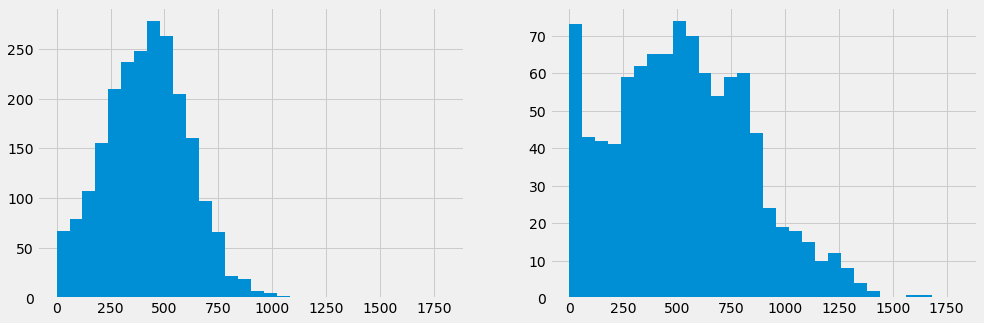

,mean,median,var,std
,sum_calls_duration,sum_calls_duration,sum_calls_duration,sum_calls_duration
tariff_name,,,,
smart,417.934948,422.0,36219.315784,190.313730
ultra,526.623350,518.0,100873.633397,317.606098


In [384]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].hist(stat[stat['tariff_name'] == 'smart']["sum_calls_duration"], range= (0,1800), bins=30, rwidth=1)
axs[1].hist(stat[stat['tariff_name'] == 'ultra']["sum_calls_duration"], range= (0,1800), bins=30, rwidth=1)

plt.show()

stat.pivot_table(index= 'tariff_name', values= 'sum_calls_duration', aggfunc= ['mean', 'median', 'var','std'])

1. Распределения в целом нормальные. Смарт смещено влево, Ультра - вправо. Есть ощущение, что пользователей Смарт поджимает ограничение в 500 минут в пакете и они не слишком далеко стараются за него выходить.
2. Средняя и медиана тарифа Смарт (418 и 422) существенно меньше, чем среднее и медиана тарифа Ультра (527 и 518) - пользователи Ультра разговаривают в среднем больше. При этом, пользователи тарифа Смарт часто выходят за пакет предоплаченных минут (500), пользователи Ультра этого не делают (3000 минут!). То есть, оператор дополнительно зарабатывает на пользователях Смарт сверх тарифа.  
3. Стандартное отклонение и дисперсия значительно выше у пользователей Ультра (318 и 100,8 тыс.), чем Смарт (190 и 36,2 тыс.). Распределение пользователей Ультра более "хвостатое" и расслабленное - все включено!

Пики на нулях - пропущенные звонки, не обращаем внимание.

### Интернет

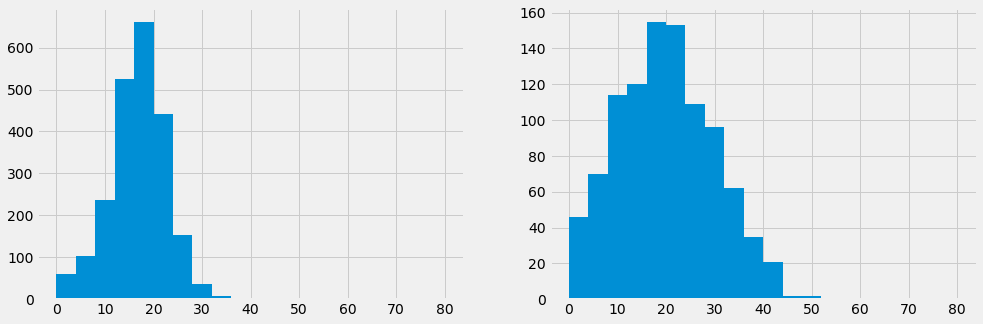

,mean,median,var,std
,sum_gb_used,sum_gb_used,sum_gb_used,sum_gb_used
tariff_name,,,,
smart,16.328847,17.0,33.028705,5.747061
ultra,19.494416,19.0,97.091686,9.853511


In [385]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].hist(stat[stat['tariff_name'] == 'smart']["sum_gb_used"], range= (0,80), bins=20, rwidth=1)
axs[1].hist(stat[stat['tariff_name'] == 'ultra']["sum_gb_used"], range= (0,80), bins=20, rwidth=1)

plt.show()

stat.pivot_table(index= 'tariff_name', values= 'sum_gb_used', aggfunc= ['mean', 'median', 'var','std'])

1. Распределения в целом нормальные. Смарт смещено влево, Ультра - вправо. Но совсем немного.
2. Средняя и медиана тарифа Смарт (16 и 17) меньше, чем среднее и медиана тарифа Ультра (19.5 и 19) - пользователи Ультра пользуются интренетом в среднем больше. При этом, пользователи обоих тарифов часто выходят за пакет предоплаченных гигабайт (15 и 30). То есть, оператор дополнительно зарабатывает на пользователях обоих тарифов.  
3. Стандартное отклонение и дисперсия значительно выше у пользователей Ультра (10 и 97), чем Смарт (6 и 33). Распределение пользователей Ультра более "хвостатое" и расслабленное и в гигабайтах тоже. Красиво жить не запретишь!

### Сообщения

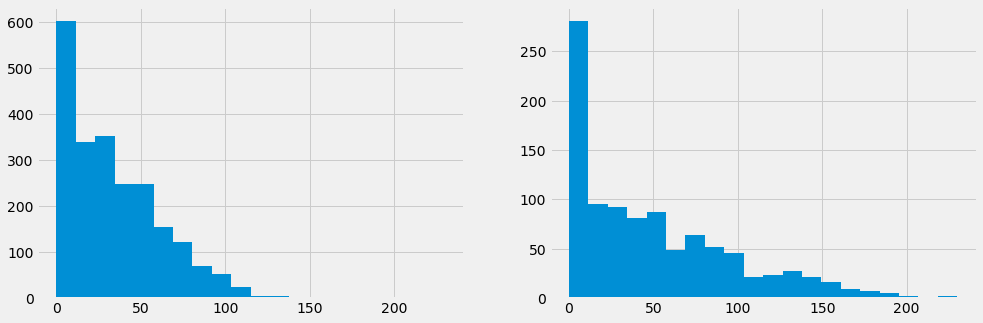

,mean,median,var,std
,count_messages,count_messages,count_messages,count_messages
tariff_name,,,,
smart,33.384029,28.0,796.812958,28.227876
ultra,49.363452,38.0,2285.266143,47.804457


In [386]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].hist(stat[stat['tariff_name'] == 'smart']["count_messages"], range= (0,230), bins=20, rwidth=1)
axs[1].hist(stat[stat['tariff_name'] == 'ultra']["count_messages"], range= (0,230), bins=20, rwidth=1)

plt.show()

stat.pivot_table(index= 'tariff_name', values= 'count_messages', aggfunc= ['mean', 'median', 'var','std'])

Много пользователей обоих тарифов смс вообще не отправляют - очевидно, пользуются мессенджерами, 21 век как-никак. Посмотрим без нулей.

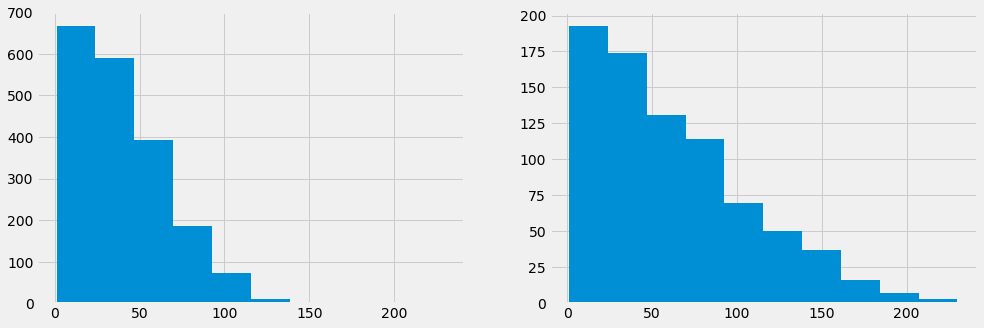

,mean,median,var,std
,count_messages,count_messages,count_messages,count_messages
tariff_name,,,,
smart,33.384029,28.0,796.812958,28.227876
ultra,49.363452,38.0,2285.266143,47.804457


In [387]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].hist(stat[stat['tariff_name'] == 'smart']["count_messages"], range= (1,230), bins=10, rwidth=1)
axs[1].hist(stat[stat['tariff_name'] == 'ultra']["count_messages"], range= (1,230), bins=10, rwidth=1)

plt.show()

stat.pivot_table(index= 'tariff_name', values= 'count_messages', aggfunc= ['mean', 'median', 'var','std'])

1. Распределения похоже на Пуассона. В основном пользователи отправляют несколько десятков смс, многие не отправляют вообще.
2. Средняя и медиана тарифа Смарт (33 и 28) меньше, чем среднее и медиана тарифа Ультра (49 и 38) - пользователи Ультра отправляют смс в среднем больше. При этом, пользователи Смарт часто выходят за пакет предоплаченных смс (50), пользователи Ультра этого не делают (1000 смс!). То есть, оператор дополнительно зарабатывает на пользователях Смарт сверх тарифа.  

### Выручка «Ультра» и «Смарт»

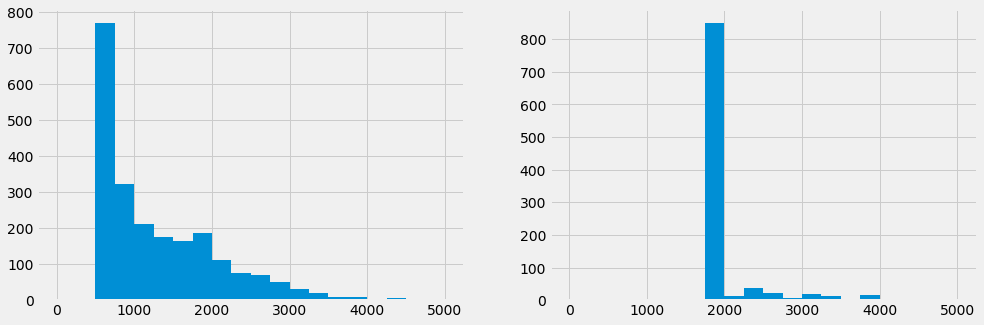

smart


count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: revenue_total, dtype: float64


Дисперсия (Smart): 669485.2209234245

ultra


count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue_total, dtype: float64


Дисперсия (Ultra): 141373.07325620347


In [389]:
stat_smart = stat.query('tariff_name == "smart"')
stat_ultra = stat.query('tariff_name == "ultra"')

plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].hist(stat_smart['revenue_total'], range= (0,5000), bins=20, rwidth=1)
axs[1].hist(stat_ultra['revenue_total'], range= (0,5000), bins=20, rwidth=1)

plt.show()

print('smart')
display(stat_smart['revenue_total'].describe())
print()
print('Дисперсия (Smart):', np.var(stat_smart['revenue_total']))
print()
print('ultra')
display(stat_ultra['revenue_total'].describe())
print()
print('Дисперсия (Ultra):', np.var(stat_ultra['revenue_total']))

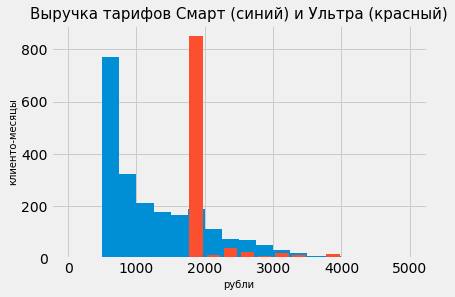

In [390]:
#посмотрим на одном графике
plt.style.use("fivethirtyeight")

plt.hist(stat_smart['revenue_total'], range= (0,5000), bins=20, rwidth=1)
plt.hist(stat_ultra['revenue_total'], range= (0,5000), bins=20, rwidth=0.8)

plt.title('Выручка тарифов Смарт (синий) и Ультра (красный)',
          fontsize=15)
plt.xlabel('рубли', fontsize=10)
plt.ylabel('клиенто-месяцы', fontsize=10)

plt.show()

1. Средняя и медиана тарифа Смарт (1290 и 1023) существенно меньше, чем среднее и медиана тарифа Ультра (2070 и 1950) - кажется, что оператор зарабатывает на Ультра в среднем больше (по имеющимся выборкам).  
2. Стандартное отклонение и дисперсия значительно выше у пользователей Смарт (818 и 669,5 тыс.), чем Ультра (376 и 141,4 тыс.). Распределение пользователей Смарт более "хвостатое", вероятно пользователи Ультра гораздо реже доплачивают сверх тарифа.

Пики на 500 и 1950 - оплата пакетов Смарт и Ультра.

### Выручка в Москве и других регионах

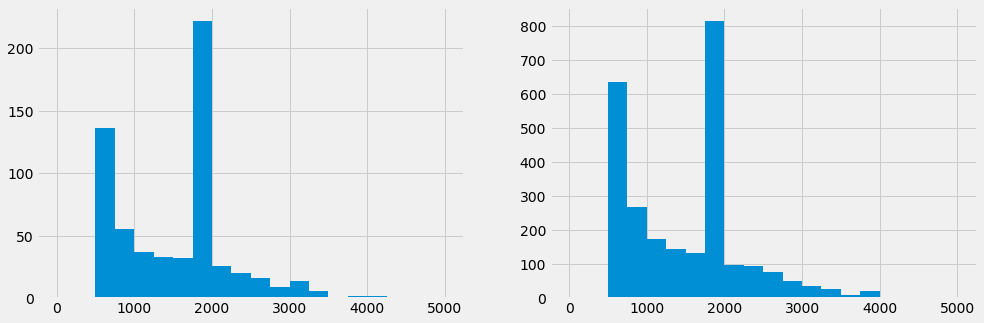

МАсква


count     611.000000
mean     1546.713584
std       752.088071
min       550.000000
25%       780.500000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: revenue_total, dtype: float64


Дисперсия (МАсква): 564710.7117467273

ЗаМКАДье


count    2603.000000
mean     1524.936227
std       808.787752
min       550.000000
25%       750.000000
50%      1583.000000
75%      1950.000000
max      6770.000000
Name: revenue_total, dtype: float64


Дисперсия (ЗаМКАДье): 653886.3270894174


In [393]:
stat_moscow = stat.query('city == "Москва"')
stat_other_city = stat.query('city != "Москва"')

plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].hist(stat_moscow['revenue_total'], range= (0,5000), bins=20, rwidth=1)
axs[1].hist(stat_other_city['revenue_total'], range= (0,5000), bins=20, rwidth=1)

plt.show()

print('МАсква')
display(stat_moscow['revenue_total'].describe())
print()
print('Дисперсия (МАсква):', np.var(stat_moscow['revenue_total']))
print()
print('ЗаМКАДье')
display(stat_other_city['revenue_total'].describe())
print()
print('Дисперсия (ЗаМКАДье):', np.var(stat_other_city['revenue_total']))

1. Средняя и медиана в Москве (1547 и 1750) совсем чуть-чуть больше, чем среднее и медиана в других регионах (1524 и 1583) - кажется, что оператор зарабатывает в Москве и регионах почти одинкаово (по имеющимся выборкам).  
2. Стандартное отклонение и дисперсия чуть ниже в Москве (752 и 564,7 тыс.), чем в регионах (808 и 653,9 тыс.). Распределение пользователей Смарт более "хвостатое", вероятно пользователи из разных регионов чуть более разнородны, чем пользователи в Москве.

Пики на 500 и 1950 - оплата пакетов Смарт и Ультра.

### Вывод

**Звонки:**  

1. Распределения в целом нормальные. Смарт смещено влево, Ультра - вправо. Есть ощущение, что пользователей Смарт поджимает ограничение в 500 минут в пакете и они не слишком далеко стараются за него выходить.
2. Средняя и медиана тарифа Смарт (418 и 422) существенно меньше, чем среднее и медиана тарифа Ультра (527 и 518) - пользователи Ультра разговаривают в среднем больше. При этом, пользователи тарифа Смарт часто выходят за пакет предоплаченных минут (500), пользователи Ультра этого не делают (3000 минут!). То есть, оператор дополнительно зарабатывает на пользователях Смарт сверх тарифа.  
3. Стандартное отклонение и дисперсия значительно выше у пользователей Ультра (318 и 100,8 тыс.), чем Смарт (190 и 36,2 тыс.). Распределение пользователей Ультра более "хвостатое" и расслабленное - все включено!

Пики на нулях - пропущенные звонки, не обращаем внимание.

**Интернет:**  

1. Распределения в целом нормальные. Смарт смещено влево, Ультра - вправо. Но совсем немного.
2. Средняя и медиана тарифа Смарт (16 и 17) меньше, чем среднее и медиана тарифа Ультра (19.4 и 19) - пользователи Ультра пользуются интренетом в среднем больше. При этом, пользователи обоих тарифов часто выходят за пакет предоплаченных гигабайт (15 и 30). То есть, оператор дополнительно зарабатывает на пользователях обоих тарифов.  
3. Стандартное отклонение и дисперсия значительно выше у пользователей Ультра (10 и 97), чем Смарт (6 и 33). Распределение пользователей Ультра более "хвостатое" и расслабленное и в гигабайтах тоже. Красиво жить не запретишь!

**Сообщения:**  

1. Распределения похоже на Пуассона. В основном пользователи отправляют несколько десятков смс, многие не отправляют вообще.
2. Средняя и медиана тарифа Смарт (33 и 28) меньше, чем среднее и медиана тарифа Ультра (49 и 38) - пользователи Ультра отправляют смс в среднем больше. При этом, пользователи Смарт часто выходят за пакет предоплаченных смс (50), пользователи Ультра этого не делают (1000 смс!). То есть, оператор дополнительно зарабатывает на пользователях Смарт сверх тарифа.  

**Общая выручка по тарифам:**  

1. Средняя и медиана тарифа Смарт (1290 и 1023) существенно меньше, чем среднее и медиана тарифа Ультра (2070 и 1950) - кажется, что оператор зарабатывает на Ультра в среднем больше (по имеющимся выборкам).  
2. Стандартное отклонение и дисперсия значительно выше у пользователей Смарт (818 и 669,5 тыс.), чем Ультра (376 и 141,4 тыс.). Распределение пользователей Смарт более "хвостатое", вероятно пользователи Ультра гораздо реже доплачивают сверх тарифа.

**Общая выручка в Москве и регионах:**  

1. Средняя и медиана в Москве (1547 и 1750) совсем чуть-чуть больше, чем среднее и медиана в других регионах (1524 и 1583) - кажется, что оператор зарабатывает в Москве и регионах почти одинкаово (по имеющимся выборкам).  
2. Стандартное отклонение и дисперсия чуть ниже в Москве (752 и 564,7 тыс.), чем в регионах (808 и 653,9 тыс.). Распределение пользователей Смарт более "хвостатое", вероятно пользователи из разных регионов чуть более разнородны, чем пользователи в Москве.

***На пользователях тарифа Смарт оператор зарабатывает сверх тарифа на звонках, смс и интернете. На пользователях Ультра - только на Интернете. Тем не менее, с учетом разницы в стоимости тарифов, по общей выручке в среднем в месяц на пользователя лидирует Ультра.***

***Кажется, что оператор зарабатывает в Москве и регионах примерно одинаково.*** 

Однако у нас только выборки, может они получились такими случайно и в генеральных совокупностях это не так?

## Проверка гипотез

Проверим t-тестами Стьюдента две нулевых гипотезы для двух разных случаев:   
1. О равенстве средних двух генеральных совокупностей: выручки пользователей тарифа Смарт и тарифа Ультра. Альтернативной гипотезой будет средняя выручка по тарифу Смарт меньше средней выручки по тарифу Ультра (2070.15 рублей в месяц). Сформулируем так альтернативную гипотезу и проверим по выручке тарифа Смарт - эта выборка больше.
2. О равенстве средних двух генеральных совокупностей: выручки пользователей из Москвы и пользователей из других регионов.

Уровень значимости зададим в размере 1%, для точности.
Представляется, что все вышеперечисленные генеральные совокупности независимы. Выборки у нас в сотни значений, этого достаточно, мы не знаем какие дисперсии у генеральных совокупностей, соответсвенно, объединять выборки не будем. 

Дополнительно проверим гипотезу о равенстве дисперсий генеральных совокупностей для тарифов Смарт и Ультра тестом Левена.

In [394]:
#st.levene(*args, center='median', proportiontocut=0.05)
st.levene(stat_smart['revenue_total'], stat_ultra['revenue_total'])

LeveneResult(statistic=604.5068994427307, pvalue=1.8783148636310733e-122)

Да, гипотезу о о равенстве дисперсий генеральных совокупностей для тарифов Смарт и Ультра тестом Левена придется отвергнуть. Действуем по плану - проверяем тестом Стьюдента гипотезу о равенстве средних двух генеральных совокупностей не объединяя выборки.

### Средняя выручка «Ультра» и «Смарт»

In [395]:
alpha = 0.01

results = st.ttest_ind(stat_smart['revenue_total'], stat_ultra['revenue_total'], equal_var = False)
print('p-значение:', results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Средние выручки совершенно точно не равны. Проверим альтернативную гипотезу: средняя выручка по тарифу Смарт меньше средней выручки по тарифу Ультра (2070.15 рублей в месяц). Сделаем односторонний тест по выборке тарифа Смарт (для этого теста нулевая гипотеза та же - средние равны, альтернативная - выручка по Смарт меньше).

In [396]:
alpha = 0.01

mean_ultra = stat_ultra['revenue_total'].mean()

results = st.ttest_1samp(stat_smart['revenue_total'], mean_ultra)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только тогда, когда выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (stat_smart['revenue_total'].mean() < mean_ultra):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение: 1.681759983e-315
Отвергаем нулевую гипотезу в пользу альтернативной


На тарифе Ультра оператор зарабатывает больше.

### Средняя выручка в Москве и других регионах

In [397]:
alpha = 0.01

results = st.ttest_ind(stat_moscow['revenue_total'], stat_other_city['revenue_total'], equal_var = False)
print('p-значение:', results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


В Москве и регионах оператор в среднем зарабатывает примерно одинаково.

## Общий вывод

**Поведение пользователей:**

***Звонки:***  

1. Представляется, что на пользователей Смарт психологически давит ограничение в 500 минут в пакете и они не слишком далеко стараются за него выходить.
2. Средняя и медиана тарифа Смарт (418 и 422) существенно меньше, чем среднее и медиана тарифа Ультра (527 и 518) - пользователи Ультра разговаривают в среднем больше. При этом, пользователи тарифа Смарт часто выходят за пакет предоплаченных минут (500), пользователи Ультра этого не делают (3000 минут!). То есть, оператор дополнительно зарабатывает на пользователях Смарт сверх тарифа.  
3. Стандартное отклонение и дисперсия значительно выше у пользователей Ультра (318 и 100,8 тыс.), чем Смарт (190 и 36,2 тыс.). Распределение пользователей Ультра более "хвостатое" и расслабленное - все включено!


***Интернет:***  
1. Средняя и медиана тарифа Смарт (16 и 17) меньше, чем среднее и медиана тарифа Ультра (19.4 и 19) - пользователи Ультра пользуются интренетом в среднем больше. При этом, пользователи обоих тарифов часто выходят за пакет предоплаченных гигабайт (15 и 30). То есть, оператор дополнительно зарабатывает на пользователях обоих тарифов.  
2. Стандартное отклонение и дисперсия значительно выше у пользователей Ультра (10 и 97), чем Смарт (6 и 33). Распределение пользователей Ультра более "хвостатое" и расслабленное и в гигабайтах тоже. Красиво жить не запретишь!

***Сообщения:***  

1. В основном пользователи отправляют несколько десятков смс, многие не отправляют вообще.
2. Средняя и медиана тарифа Смарт (33 и 28) меньше, чем среднее и медиана тарифа Ультра (49 и 38) - пользователи Ультра отправляют смс в среднем больше. При этом, пользователи Смарт часто выходят за пакет предоплаченных смс (50), пользователи Ультра этого не делают (1000 смс!). То есть, оператор дополнительно зарабатывает на пользователях Смарт сверх тарифа.  

**Зоны роста выручки:**

На пользователях тарифа Смарт оператор зарабатывает сверх тарифа на звонках, смс и интернете. На пользователях Ультра - только на Интернете. Тем не менее, с учетом разницы в стоимости тарифов, **по общей выручке в среднем в месяц на пользователя лидирует Ультра (2070 против 1290 рублей в месяц с пользователя)**.  

При этом, в Москве и регионах оператор зарабатывает примерно одинаково в среднем в месяц на пользователя, поэтому региональные различие несущественны для увеличения выручки.

**Таким образом, драйвером роста выручки компании может стать увеличение доли сегмента Ультра в клиентской базе**.



*Ниже представлена визуализация распределения выручки по тарифам Смарт и Ультра*

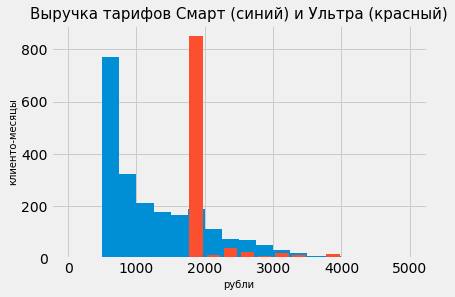

In [400]:
#посмотрим на одном графике
plt.style.use("fivethirtyeight")
plt.hist(stat_smart['revenue_total'], range= (0,5000), bins=20, rwidth=1)
plt.hist(stat_ultra['revenue_total'], range= (0,5000), bins=20, rwidth=0.8)
plt.title('Выручка тарифов Смарт (синий) и Ультра (красный)', fontsize=15)
plt.xlabel('рубли', fontsize=10)
plt.ylabel('клиенто-месяцы', fontsize=10)
plt.show()